In [1]:
"""
@author Y Ying
python 3.9.7
This converts ALL .pdb file in the directory for gag 
lattices output from NERDSS to a .csv of all centers of
mass (CoMs) of gag.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def read_pdb(filename):
    """
    read .pdb file for gag lattices and return dataframe
    with header renamed. Note the last two columns are
    only placeholder for pdb file format.
    """
    df = pd.read_csv(filename, skiprows = 2, sep = "\s+", header = None) #"\s+" for undefined number of spaces
    df.columns = ["Type", "Index", "Particle", "Molecule", "Molecule Index", "X", "Y", "Z", "Occupancy", "Atom"]
    return df

In [3]:
def get_COM_coord(df, drop = False):
    """
    Extract coordinate data (XYZ) of COM from the input
    dataframe based on "Particle" property. Drop all
    other properties when set to drop = True.
    """
    df_COM = df.loc[df['Particle'] == "COM"].reset_index(drop = True)
    if drop:
        df_COM = df_COM.drop(columns =\
                             ["Type", "Particle", "Index", "Molecule", "Molecule Index", "Occupancy", "Atom"])
    return df_COM

In [4]:
def convert_all_to_csv(readDir = "./", saveDir = "./csv/"):
    """
    Iterate over readDir where this file is in, select
    the files that end with .pdb, and convert them to
    .csv with only COM coord. Save .csv in saveDir.
    """
    directory = os.fsencode(readDir)
    
    #create save directory if not exists
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    
    for file in os.listdir(directory):
        #iteratre over directory
        filename = os.fsdecode(file)
        if filename.endswith(".pdb"):

            #read files that end with .pdb
            print(f"Read {filename}") 
            df = read_pdb(filename)
            df = get_COM_coord(df, drop = True)

            #convert filename to "x.csv"
            filenameCsv = saveDir + filename[:-3] + "csv"

            #write to .csv
            print(f"Write to {filenameCsv}")
            df.to_csv(filenameCsv, header = False, index = False)

        else:
            #skip file
            print(f"Skip {filename}")
    
    return True

In [5]:
convert_all_to_csv()

Read 2500gags.pdb
Write to ./csv/2500gags.csv
Skip 3125gags.csv
Skip 1250gags.csv
Skip .DS_Store
Skip 1875gags.csv
Skip convert_pdb_to_xyz_CoM.ipynb
Skip 2500gags.csv
Read 3125gags.pdb
Write to ./csv/3125gags.csv
Read 1250gags.pdb
Write to ./csv/1250gags.csv
Skip 213gags_COM.xlsx
Read 1875gags.pdb
Write to ./csv/1875gags.csv
Skip csv
Skip 625gags.csv
Skip .ipynb_checkpoints
Read 625gags.pdb
Write to ./csv/625gags.csv


True

3D plot ngags
==

In [6]:
from mpl_toolkits import mplot3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [17]:
gags213 = pd.read_excel("213gags_COM.xlsx", header = None)
gags213.columns = ["x","y","z"]

gags625 = pd.read_csv("./csv/3125gags.csv")
gags625.columns = ["x","y","z"]

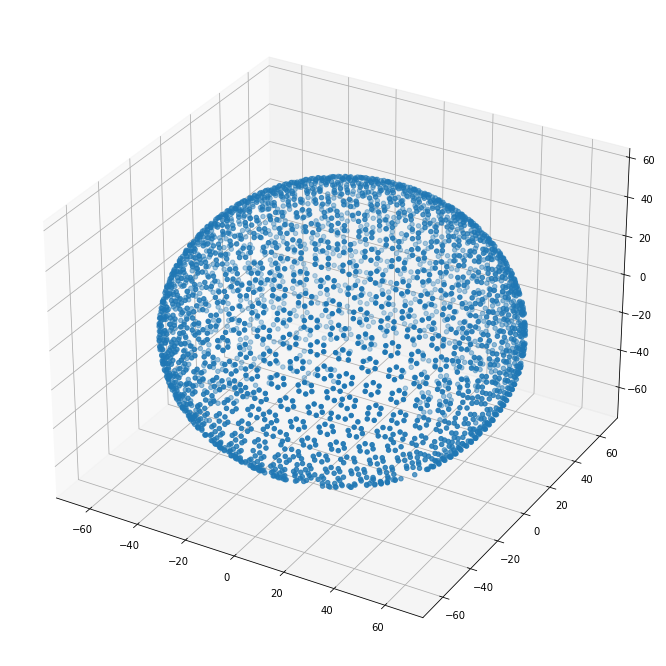

In [18]:
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection ="3d")

# Plot the surface.
#surf = ax.plot_trisurf(gags213["x"], gags213["y"], gags213["z"], cmap="Blues", alpha = 0.6)
#surf = ax.plot_trisurf(gags625["x"], gags625["y"], gags625["z"], cmap="Blues", alpha = 0.6)
ax.scatter3D(gags625["x"], gags625["y"], gags625["z"])

Best fit plane and rotation
==

In [9]:
"""
In [8], we can see that the gag lattice is not always facing
upwards, the way I deal with it is to find the best fit plane
and rotate it so that the normal vector is pointing upwards.
"""
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d

In [10]:
points625 = Points(gags625.to_numpy())
plane625 = Plane.best_fit(points625)
plane625

Plane(point=Point([51.61202458, 23.55448848, 89.15412903]), normal=Vector([-0.30101166, -0.86177338,  0.4083364 ]))

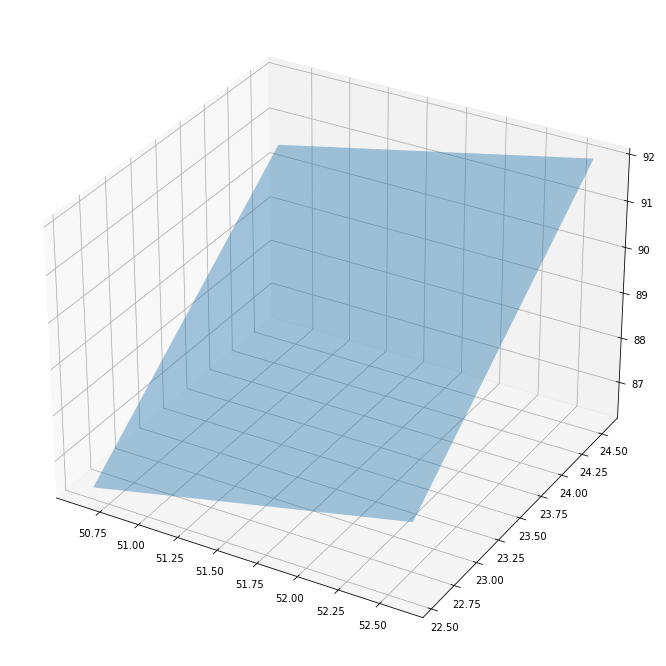

In [11]:
"""
Plot best fit plane
"""
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(111, projection='3d')
#ax2 = fig.add_subplot(111, projection='3d')

#points625.plot_3d(ax1, c='k', s=50, depthshade=False)
plane625.plot_3d(ax1, alpha = 0.4)

In [12]:
"""
https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
Get rotation matrix based on this method.
v = a x b
c = a dot b -- scalar = 1/(1 + c)
[vx] = [[0, -v[2], v[1]]
        [v[2], 0, -v[0]]
        [-v[1], v[0], 0]]
[R] = [I] + [vx] + [vx]^2 1/(1 + c)
"""
def get_rotation_matrix(vStart, vEnd):
    """
    Get one solution of rotation matrix that rotates vStart to vEnd.
    """
    # v = a x b
    v = np.cross(vStart, vEnd)
    # c = a dot b
    c = np.dot(vStart, vEnd)
    scalar = 1.0 / (1 + c)
    #[vx] = [[0, -v[2], v[1]]
    #   [v[2], 0, -v[0]]
    #   [-v[1], v[0], 0]]
    vxMat = np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])
    # [R] = [I] + [vx] + [vx]^2 1/(1 + c)
    RMat = np.identity(3) + vxMat + np.dot(vxMat, vxMat) * scalar
    return RMat

In [13]:
vStart = plane625.normal
vEnd = np.array([0.0, 0.0, 1.0])
RMat = get_rotation_matrix(vStart, vEnd)

# iterator over Points and calculate rotated
points625Rotated = np.zeros(np.shape(points625)) # initialize
for (pointStart, pointRotated) in zip(points625, points625Rotated):
    pointRotated += np.dot(RMat, pointStart) # MUST USE += here

#get dataframe
df_points625Rotated = pd.DataFrame(points625Rotated)
df_points625Rotated.columns = (["x", "y", "z"])
df_points625Rotated

,x,y,z
0,67.265105,70.501224,14.028485
1,100.860043,78.361680,6.918171
2,74.337362,72.945777,14.201180
3,73.803683,87.462780,13.525944
4,96.846157,75.892417,8.865515
...,...,...,...
646,81.568170,119.689802,-2.729258
647,115.682761,64.586394,-5.502068
648,14.730358,94.992467,-22.434906
649,29.624062,59.366902,-3.244884


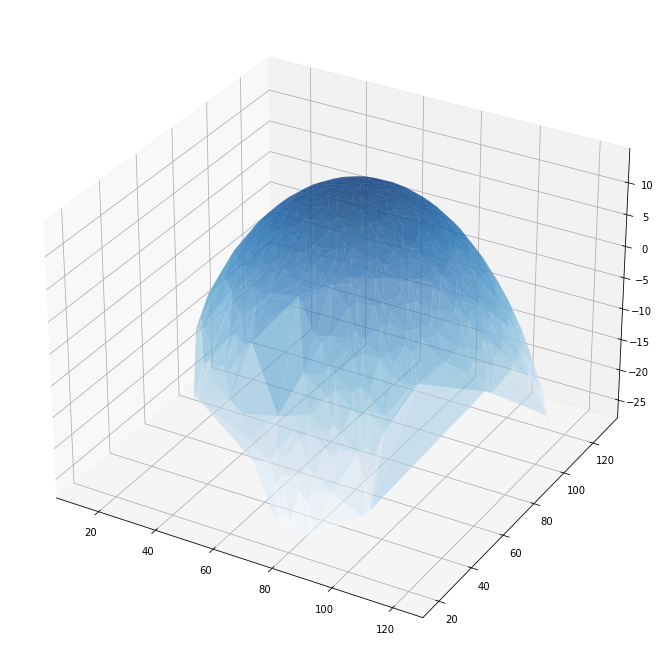

In [14]:
fig = plt.figure(figsize=(24, 12))
ax = plt.axes(projection ="3d")

# Plot the surface.
#surf = ax.plot_trisurf(gags213["x"], gags213["y"], gags213["z"], cmap="Blues", alpha = 0.6)
surf = ax.plot_trisurf(df_points625Rotated["x"], df_points625Rotated["y"], df_points625Rotated["z"], cmap="Blues", alpha = 0.6)
#ax.scatter3D(df_points625Rotated["x"], df_points625Rotated["y"], df_points625Rotated["z"])

Bulk convert
==

In [15]:
def convert_and_rotate_all(readDir = "./", saveDir = "./csv/"):
    """
    Combine conversion to .csv and rotation. Rotate gag
    lattice such that the normal vector of best fitting
    plane of the resulting gag lattice is pointing in
    positive z-dir. Output .csv file.
    
    Dependency: scikit-spatial
    """
    directory = os.fsencode(readDir)
    
    #create save directory if not exists
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    
    for file in os.listdir(directory):
        #iteratre over directory
        filename = os.fsdecode(file)
        if filename.endswith(".pdb"):

            #read files that end with .pdb
            print(f"Read {filename}") 
            df = read_pdb(filename)
            df = get_COM_coord(df, drop = True)
            
            #get best fit plane
            points = Points(df.to_numpy())
            plane = Plane.best_fit(points)
            
            #calculate rotation matrix RMat
            vStart = plane.normal
            vEnd = np.array([0.0, 0.0, 1.0]) #positive z-dir
            RMat = get_rotation_matrix(vStart, vEnd)

            # iterator over Points and calculate rotated; calculate sum for zeroing CoM
            pointsRotated = np.zeros(np.shape(points)) # initialize
            sumCOM = np.zeros([3]) # sum for zeroing CoM
            for (pointStart, pointRotated) in zip(points, pointsRotated):
                pointRotated += np.dot(RMat, pointStart) # MUST USE += here
                sumCOM += pointRotated
            
            # zero CoM
            avgCOM = sumCOM / (np.shape(pointsRotated)[0])
            for pointRotated in pointsRotated:
                pointRotated -= avgCOM

            #get dataframe
            df_pointsRotated = pd.DataFrame(pointsRotated)
            df_pointsRotated.columns = (["x", "y", "z"])

            #convert filename to "x.csv"
            filenameCsv = saveDir + filename[:-3] + "csv"

            #write to .csv
            print(f"Write to {filenameCsv}")
            df_pointsRotated.to_csv(filenameCsv, header = False, index = False)

        else:
            #skip file
            print(f"Skip {filename}")
    
    return True
    

In [16]:
convert_and_rotate_all()

Read 2500gags.pdb
Write to ./csv/2500gags.csv
Skip 3125gags.csv
Skip 1250gags.csv
Skip .DS_Store
Skip 1875gags.csv
Skip convert_pdb_to_xyz_CoM.ipynb
Skip 2500gags.csv
Read 3125gags.pdb
Write to ./csv/3125gags.csv
Read 1250gags.pdb
Write to ./csv/1250gags.csv
Skip 213gags_COM.xlsx
Read 1875gags.pdb
Write to ./csv/1875gags.csv
Skip csv
Skip 625gags.csv
Skip .ipynb_checkpoints
Read 625gags.pdb
Write to ./csv/625gags.csv


True